### Set up parameters

In [1]:
name = "instacart"

target_entity = "order_products"

entity_col = "orders.user_id"
time_col = "orders.order_date"

window_size = "2w"
minimum_data = "2023-01-01"
maximum_data = "2023-11-01"

### Dataset

##### Load data

In [2]:
from trane.datasets import load_instacart
dataframes, relationships = load_instacart()

##### Denormalize dataset

In [3]:
from trane.parsing import denormalize
import pandas as pd

df = denormalize(
    dataframes,
    relationships,
    target_entity
)
df = df.dropna()

##### Infer metadata

In [4]:
from trane.typing import infer_table_meta
meta = infer_table_meta(df, entity_col, time_col)

/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/trane/typing/inference_functions.py:195: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  pd.to_datetime(
/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/trane/typing/inference_functions.py:195: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  pd.to_datetime(
/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/trane/typing/inference_functions.py:195: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the defau

##### Manually set metadata for columns which were not inferred automatically

In [5]:
from trane.typing.column_schema import ColumnSchema
from trane.typing.logical_types import Categorical

meta["orders.eval_set"] = ColumnSchema(Categorical, semantic_tags={"category"})
meta["products.aisles.aisle"] = ColumnSchema(Categorical, semantic_tags={"category"})
meta["products.departments.department"] = ColumnSchema(Categorical, semantic_tags={"category"})
meta["products.product_name"] = ColumnSchema(Categorical, semantic_tags={"category"})

## Trane

### Generate prediction problems

In [6]:
from trane import CutoffStrategy

cutoff_strategy = CutoffStrategy(
    entity_col=entity_col,
    window_size=window_size,
    minimum_data=minimum_data,
    maximum_data=maximum_data,
)

from trane import PredictionProblemGenerator
problem_generator = PredictionProblemGenerator(
    df=df,
    table_meta=meta,
    entity_col=entity_col,
    cutoff_strategy=cutoff_strategy,
    time_col=time_col,
)
problems = problem_generator.generate(df, generate_thresholds=True)

  0%|          | 0/4104 [00:00<?, ?it/s]

##### Output all prediction problems to a file

In [7]:
with open("generated_problems.txt", "w") as text_file:
    for idx, p in enumerate(problems):
        print(idx, p, file=text_file)

### Find a relevant problem
Look through the generated_problems.txt file and find the ID of an interesting problem

In [12]:
ex = problems[273].execute(df, num_examples_per_instance=-1)
problems[273]

Elapsed: 00:54 | Remaining: 00:00 | Progress: 100%|██████████| orders.user_id: 10000/10000 


For each <orders.user_id> predict if there exists a record with <products.product_name> equal to Banana in next 2w days

### Feature engineering
Using Featuretools

/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/featuretools/entityset/entityset.py:1910: UserWarning: index __id__ not found in dataframe, creating new integer column
  warnings.warn(
/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/woodwork/type_sys/utils.py:40: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  pd.to_datetime(
/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/woodwork/type_sys/utils.py:40: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  pd.to_datetime(
/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/woodwork/ty

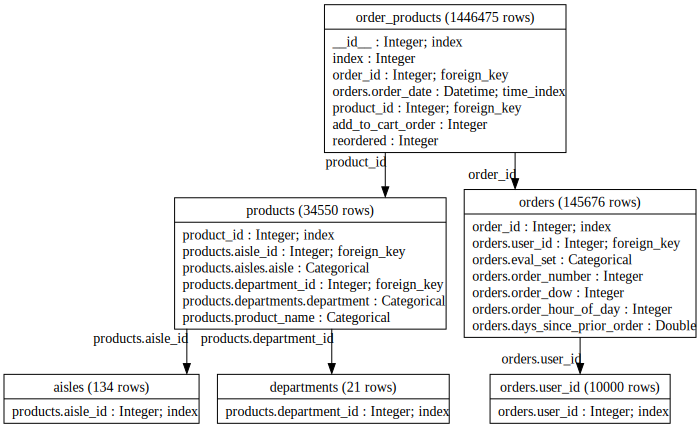

In [13]:
import featuretools as ft

es = ft.EntitySet(name)

es.add_dataframe(
    dataframe=df.reset_index(),
    dataframe_name="order_products",
    time_index="orders.order_date",
    index="__id__",
)

es.normalize_dataframe(
    base_dataframe_name="order_products",
    new_dataframe_name="products",
    index="product_id",
    additional_columns=["products.aisle_id", "products.aisles.aisle", "products.department_id", "products.departments.department", "products.product_name"],
    make_time_index=False,
)

es.normalize_dataframe(
    base_dataframe_name="order_products",
    new_dataframe_name="orders",
    index="order_id",
    additional_columns=["orders.user_id", "orders.eval_set", "orders.order_number", "orders.order_dow", "orders.order_hour_of_day", "orders.days_since_prior_order"],
    make_time_index=False,
)

es.normalize_dataframe(
    base_dataframe_name="products",
    new_dataframe_name="aisles",
    index="products.aisle_id",
    make_time_index=False,
)

es.normalize_dataframe(
    base_dataframe_name="products",
    new_dataframe_name="departments",
    index="products.department_id",
    make_time_index=False,
)

es.normalize_dataframe(
    base_dataframe_name="orders",
    new_dataframe_name="orders.user_id",
    index="orders.user_id",
    make_time_index=False,
)

es.plot()

In [14]:
fm, fd = ft.dfs(
    entityset=es,
    target_dataframe_name=entity_col,
    cutoff_time=ex,
    cutoff_time_in_index=True,
    include_cutoff_time=False,
    verbose=True,
)

fm.reset_index(drop=True, inplace=True)
y = fm.ww.pop('_execute_operations_on_df')
X = fm

Built 170 features
Elapsed: 02:33 | Progress: 100%|██████████


### Machine Learning

##### Train/Test split by time cutoff

In [16]:
train_cutoff = pd.to_datetime("2023-09-01")
X_train, y_train = X[ex["time"] <= train_cutoff], y[ex["time"] <= train_cutoff]
X_test, y_test = X[ex["time"] > train_cutoff], y[ex["time"] > train_cutoff]

##### Train a model

In [17]:
import lightgbm as lgb
model = lgb.LGBMClassifier()

model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 11517, number of negative: 54026
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28861
[LightGBM] [Info] Number of data points in the train set: 65543, number of used features: 161
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175717 -> initscore=-1.545641
[LightGBM] [Info] Start training from score -1.545641


LGBMClassifier()

##### Run inference on the test set

In [18]:
y_hat = model.predict(X_test)

##### Evaluate model on the test set

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.show()

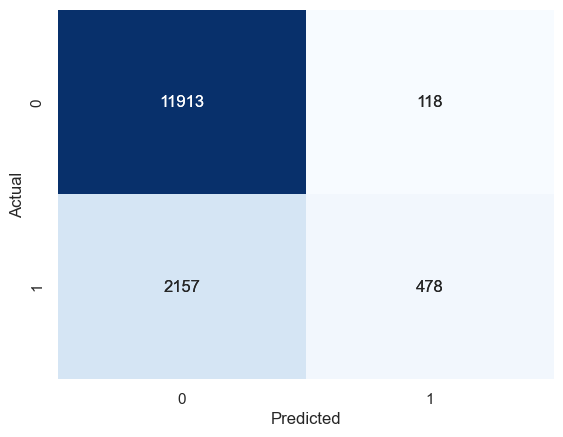

In [21]:
%matplotlib inline
plot_confusion_matrix(y_test, y_hat)

In [23]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
print(f"AUC: {round(roc_auc_score(y_test, y_hat), 2)}")
print(f"F1 Score: {round(f1_score(y_test, y_hat), 2)}")
print(f"Accuracy: {round(accuracy_score(y_test, y_hat), 2)}")

AUC: 0.59
F1 Score: 0.3
Accuracy: 0.84
